The Airline Passenger Satisfaction dataset comes from the website mavenanalytics and consists of Customer satisfaction scores from 120,000+ airline passengers, including additional information about each passenger, their flight, and type of travel, as well as their evaluation of different factors like cleanliness, comfort, service, and overall experience

In this notebook I will do:
- Exploratory Analysis in which I will try to answer:
    1. Which percentage of airline passengers are satisfied? Does it vary by customer type? What about the type of travel?
    2. What is the customer profile for a repeating airline passenger?
    3. Does flight distance affect customer preferences or flight patterns?
    4. Which factors contribute to customer satisfaction the most? What about dissatisfaction?
- Basic data cleaning (data provided by the website is not messy)
- Try to predict the Satisfaction of Passengers by creating Machine Learning Classifiers for 3 approaches:
    1. I will use most of the available columns and perform GRIDSearch for some of the models to see if there is a chance for improvement
    2. I will create a new feater called Average Score which will be the average score of columns in which the customer expresses his flight. In some of those columns, we observe answer 0 which responds to "not applicable". We will check if creating a new feature will improve the model's performance.
    3. I will create a Classifier that will use only data which is available to the company immediately after the plane will land at its final destination and will try to predict which customers could be dissatisfied. This approach would allow the company to find some of those customers and try to reach them and give them some benefits so they could use the airline's offer again in the future. 

In [1]:
# IMPORTING LIBRARIES

# General Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Machine Learning Libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC


from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn import metrics

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
df = pd.read_csv(r'C:\\Users\\Bruce\\Downloads\\Airline+Passenger+Satisfaction\\airline_passenger_satisfaction.csv')

In [3]:
#Creation of 2 additional datasets which will be used in Notebook
#Dataset with Average Score column
df_average_score = df.copy()
df_test = df[['Departure and Arrival Time Convenience', 'Ease of Online Booking',
       'Check-in Service', 'Online Boarding', 'Gate Location',
       'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness',
       'Food and Drink', 'In-flight Service', 'In-flight Wifi Service',
       'In-flight Entertainment', 'Baggage Handling']]
df_test['Average Score'] =(df_test.sum(axis=1)/ (len(df_test.columns) - (df_test == 0).astype(int).sum(axis=1))).round(1)
df_average_score.insert(0, "Average Score", df_test['Average Score'])

#Dataset which we will use for fast responding model
df_fast_model = df[['Gender', 'Age', 'Customer Type', 'Type of Travel', 'Class',
       'Flight Distance', 'Departure Delay', 'Arrival Delay','Satisfaction']]

#                      Exploratory Data Analysis

In [4]:
df.columns

Index(['ID', 'Gender', 'Age', 'Customer Type', 'Type of Travel', 'Class',
       'Flight Distance', 'Departure Delay', 'Arrival Delay',
       'Departure and Arrival Time Convenience', 'Ease of Online Booking',
       'Check-in Service', 'Online Boarding', 'Gate Location',
       'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness',
       'Food and Drink', 'In-flight Service', 'In-flight Wifi Service',
       'In-flight Entertainment', 'Baggage Handling', 'Satisfaction'],
      dtype='object')

In [5]:
df.isnull().sum()

ID                                          0
Gender                                      0
Age                                         0
Customer Type                               0
Type of Travel                              0
Class                                       0
Flight Distance                             0
Departure Delay                             0
Arrival Delay                             393
Departure and Arrival Time Convenience      0
Ease of Online Booking                      0
Check-in Service                            0
Online Boarding                             0
Gate Location                               0
On-board Service                            0
Seat Comfort                                0
Leg Room Service                            0
Cleanliness                                 0
Food and Drink                              0
In-flight Service                           0
In-flight Wifi Service                      0
In-flight Entertainment           

In [6]:
df = df.dropna()

In [7]:
cat_col = df.select_dtypes(include = ['object']) 
num_col = df.select_dtypes(include = ['int64' ,'float64'])
cat_col.shape , num_col.shape

((129487, 5), (129487, 19))

We have a total of 5 categorical columns and 19 numerical columns

In [8]:
df = df.drop(['ID'], axis=1)

There is no need to keep ID column because it will only misslead models

In [9]:
for i in df.columns[df.dtypes == 'object']:
    print(df[i].value_counts())
    print('************************')

Female    65703
Male      63784
Name: Gender, dtype: int64
************************
Returning     105773
First-time     23714
Name: Customer Type, dtype: int64
************************
Business    89445
Personal    40042
Name: Type of Travel, dtype: int64
************************
Business        61990
Economy         58117
Economy Plus     9380
Name: Class, dtype: int64
************************
Neutral or Dissatisfied    73225
Satisfied                  56262
Name: Satisfaction, dtype: int64
************************


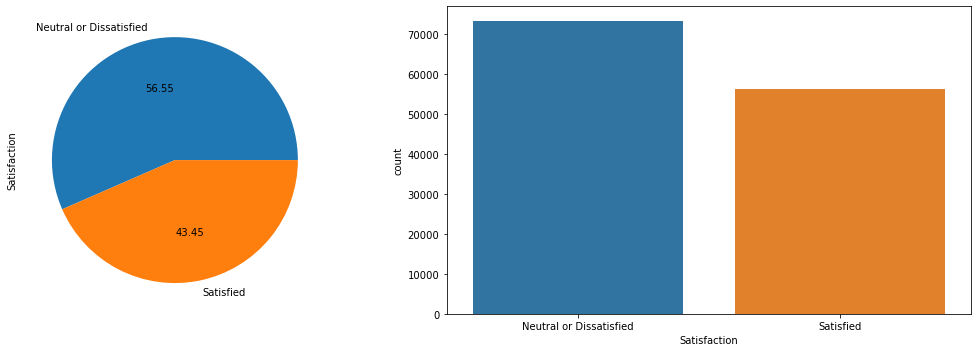

In [10]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
df['Satisfaction'].value_counts().plot(kind ='pie',autopct ='%.2f')
plt.subplot(1,2,2)
sns.countplot(df['Satisfaction'])
plt.tight_layout()

There is no imballanced in Satisfaction feature so there will be no need for either Owersampling or 
Undersampling techniques

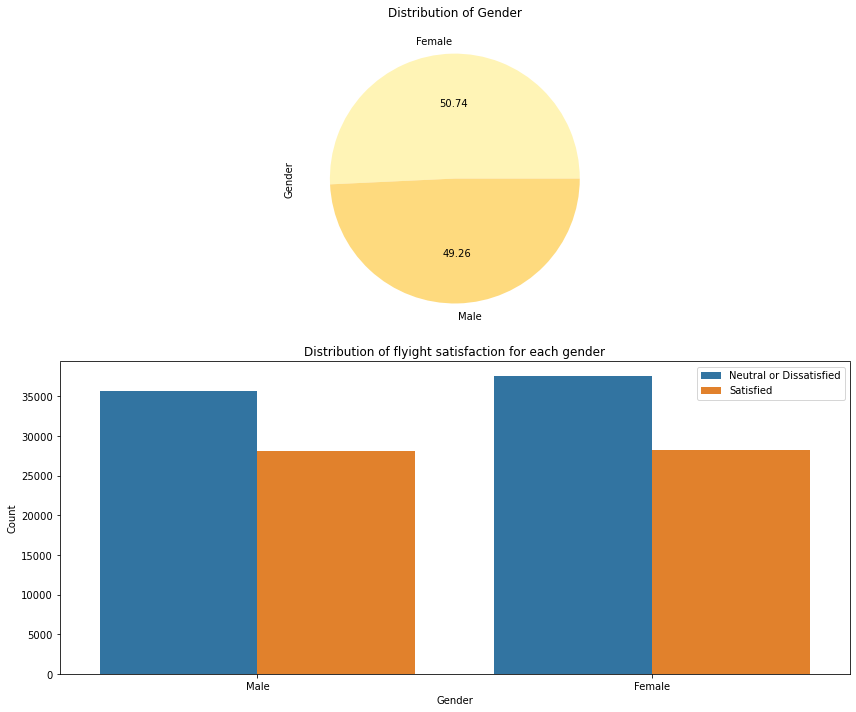

In [11]:
# Gender Column
plt.figure(figsize = (12,10))
plt.subplot(2,2,(1,2))
df['Gender'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Distribution of Gender',loc='center')


fig = plt.gcf()
plt.subplot(2,2,(3,4))
fig.set_size_inches(12, 10)
plot = sns.countplot(x='Gender', hue='Satisfaction',data=df)
plot.set(xlabel='Gender', ylabel = 'Count')
plt.title('Distribution of flyight satisfaction for each gender')
plt.legend(loc=1);

plt.tight_layout()

Gender column show us that it is balanced  and also the Satisfaction level is almost similar for Men and Women

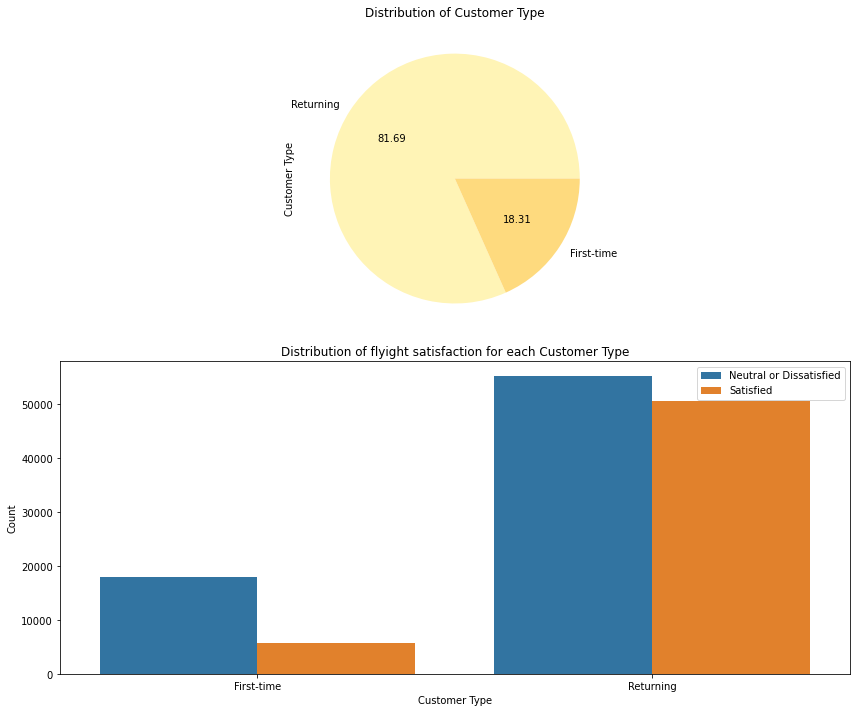

In [12]:
# Returning Column
plt.figure(figsize = (12,10))
plt.subplot(2,2,(1,2))
df['Customer Type'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Distribution of Customer Type',loc='center')


fig = plt.gcf()
plt.subplot(2,2,(3,4))
fig.set_size_inches(12, 10)
plot = sns.countplot(x='Customer Type', hue='Satisfaction',data=df)
plot.set(xlabel='Customer Type', ylabel = 'Count')
plt.title('Distribution of flyight satisfaction for each Customer Type')
plt.legend(loc=1);

plt.tight_layout()

Most of the of the customers are the Returning one's and there is seem to be easier group to satisfy. In First-time group the percent of Neutral or Dissatisfied is much bigger.

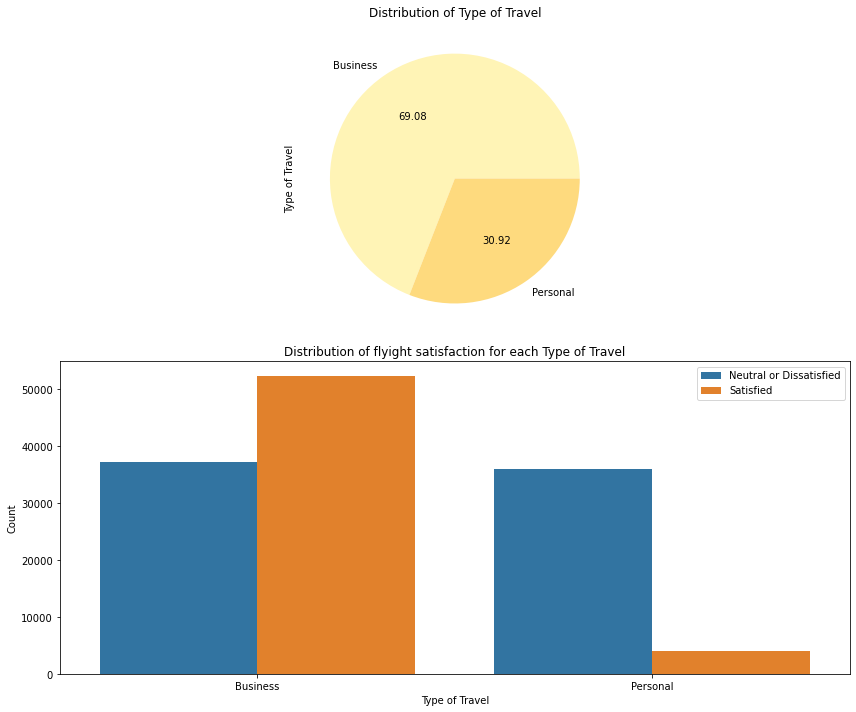

In [13]:

# Type of Travel Column
plt.figure(figsize = (12,10))
plt.subplot(2,2,(1,2))
df['Type of Travel'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Distribution of Type of Travel',loc='center')


fig = plt.gcf()
plt.subplot(2,2,(3,4))
fig.set_size_inches(12, 10)
plot = sns.countplot(x='Type of Travel', hue='Satisfaction',data=df)
plot.set(xlabel='Type of Travel', ylabel = 'Count')
plt.title('Distribution of flyight satisfaction for each Type of Travel')
plt.legend(loc=1);

plt.tight_layout()

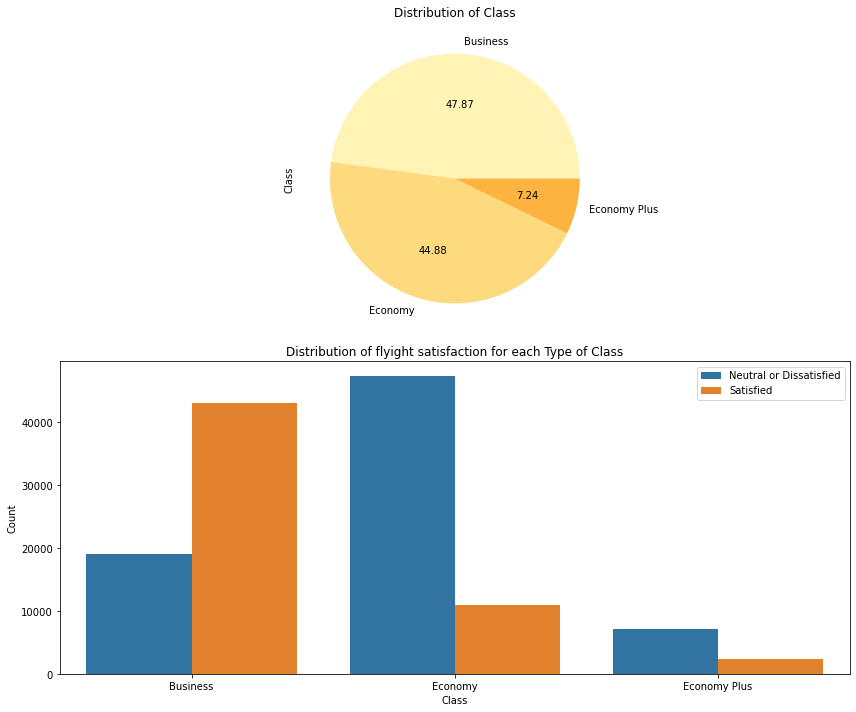

In [14]:
# Class Column
plt.figure(figsize = (12,10))
plt.subplot(2,2,(1,2))
df['Class'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Distribution of Class',loc='center')


fig = plt.gcf()
plt.subplot(2,2,(3,4))
fig.set_size_inches(12, 10)
plot = sns.countplot(x='Class', hue='Satisfaction',data=df)
plot.set(xlabel='Class', ylabel = 'Count')
plt.title('Distribution of flyight satisfaction for each Type of Class')
plt.legend(loc=1);

plt.tight_layout()

Which percentage of airline passengers are satisfied? Does it vary by customer type? What about the type of travel?
- Gender feature does not have an effect on the Satisfication of passengers. We observe almost the same proportions between Male and Female customers
- Returning Customers are much more likely to be Satisfied with the flight than the First time ones. There is also a bigger group than the new ones.
- Business customers are more often Satisfied than Personal customers. It may be explained by the fact that those customers are not paying for those trips and due to
that they might forgive more than people who pay their money for flights.
- In the Type of Class column we can observe that in the Business class Satisfaction customers are the majority and for Economy Plus and Economy those levels are dropping.
This can be explained because of differences in customer service and on-flight services(better food/drinks, more space for legs) in the business class.

In [15]:
df_returning_cus = df[df['Customer Type'] == 'Returning']
df_first_time = df[df['Customer Type'] == 'First-time']

In [16]:
df_first_time['Type of Travel'].value_counts()

Business    23515
Personal      199
Name: Type of Travel, dtype: int64

Text(0.5, 1.0, 'Gender - First Time')

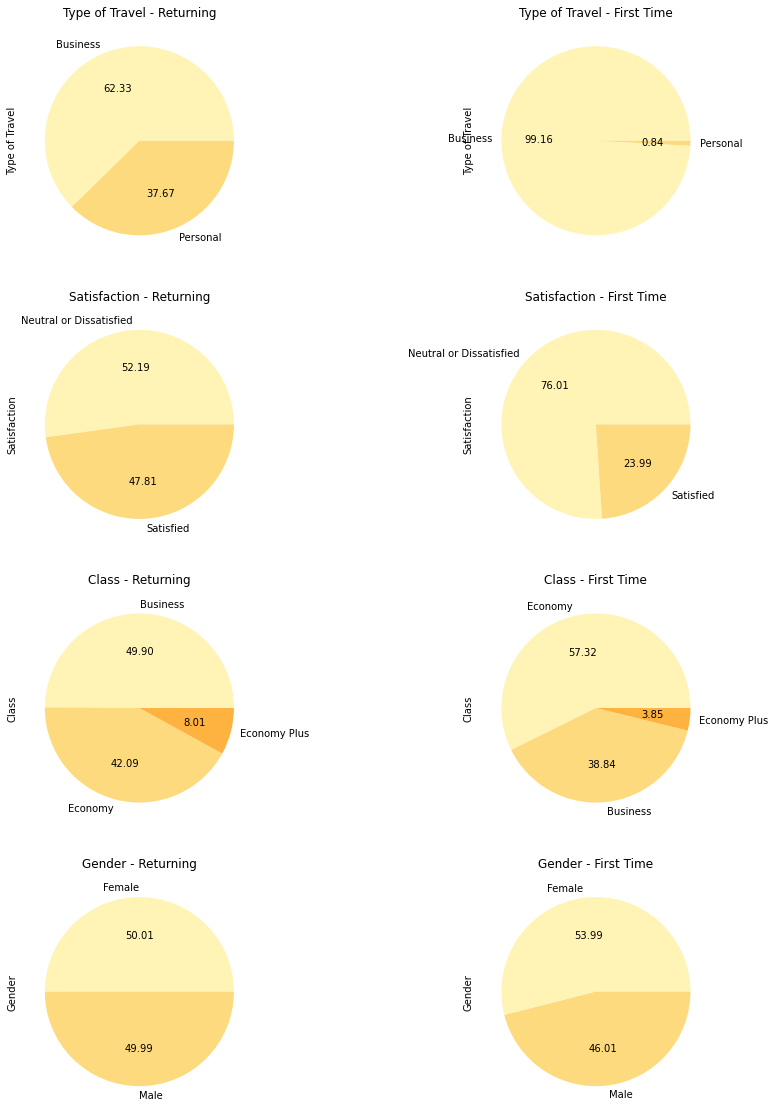

In [17]:
plt.figure(figsize = (15,20))
plt.subplot(4,2,1)
df_returning_cus['Type of Travel'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Type of Travel - Returning',loc='center')
plt.subplot(4,2,2)
df_first_time['Type of Travel'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Type of Travel - First Time',loc='center')

plt.subplot(4,2,3)
df_returning_cus['Satisfaction'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Satisfaction - Returning',loc='center')
plt.subplot(4,2,4)
df_first_time['Satisfaction'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Satisfaction - First Time',loc='center')


plt.subplot(4,2,5)
df_returning_cus['Class'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Class - Returning',loc='center')
plt.subplot(4,2,6)
df_first_time['Class'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Class - First Time',loc='center')

plt.subplot(4,2,7)
df_returning_cus['Gender'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Gender - Returning',loc='center')
plt.subplot(4,2,8)
df_first_time['Gender'].value_counts().plot(kind='pie',autopct ='%.2f',colors = sns.color_palette("YlOrBr"))
plt.title('Gender - First Time',loc='center')

In [18]:
df_mean = pd.DataFrame({'Age AVG':[df_first_time['Age'].mean(),df_returning_cus['Age'].mean()],'Flight Distance Avg':[df_first_time['Flight Distance'].mean(),df_returning_cus['Flight Distance'].mean()]},index=['First_time','Returning'])
df_mean

,Age AVG,Flight Distance Avg
First_time,30.352534,713.79122
Returning,41.463625,1297.02252


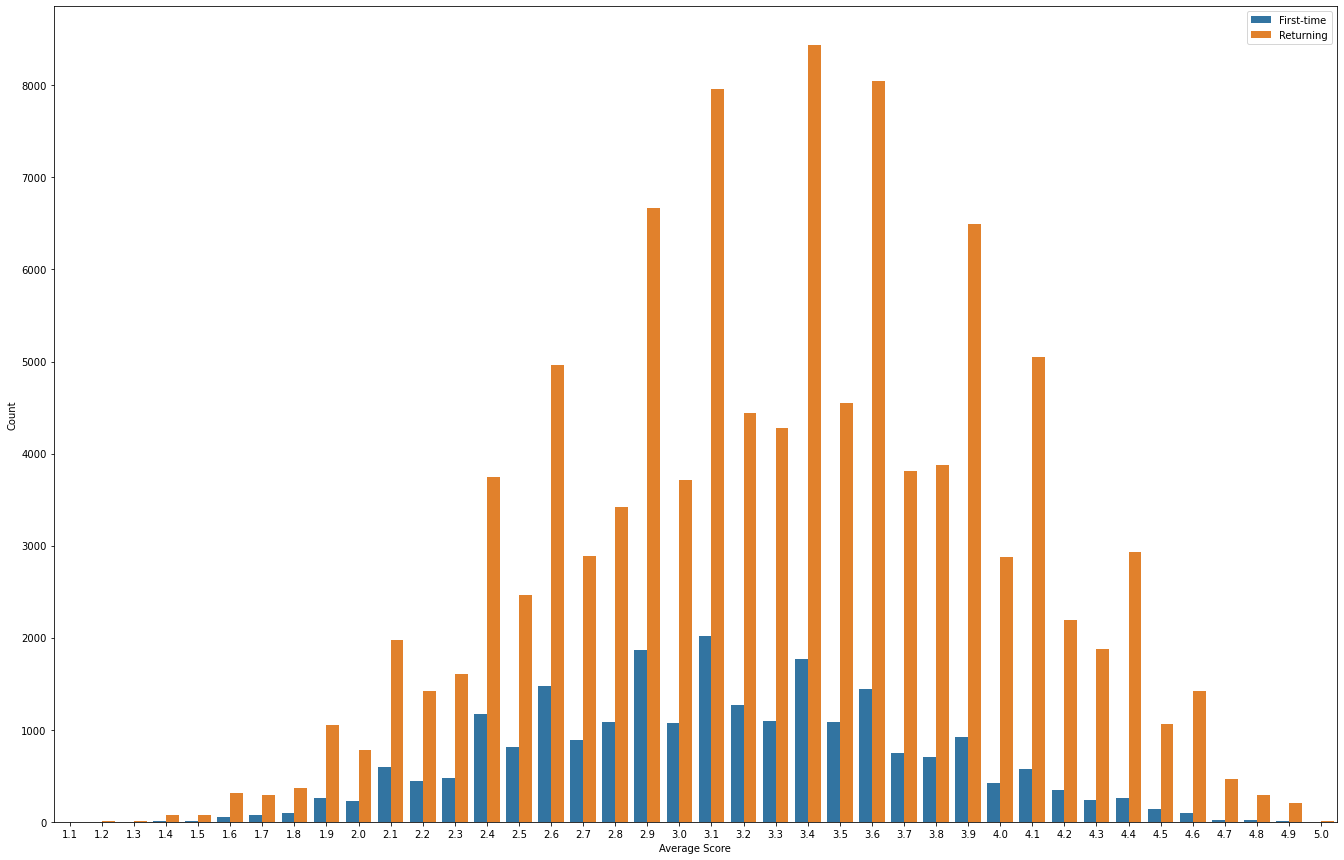

In [19]:
fig = plt.gcf()
fig.set_size_inches(23, 15)
plot = sns.countplot(x='Average Score', hue='Customer Type', data= df_average_score)
plot.set(xlabel='Average Score', ylabel = 'Count')
plt.legend(loc=1);

What is the customer profile for a repeating airline passenger?
- We can observe that in Returning Class there is Majority of Business type and 37 percent of Personal type travel. Comparing to First Timers where 99 percent of them are Business types. 
There should be an investigation if there are no data mistakes here.
- There is a decrease in Satisfaction levels when compared to First Timers
- For Type of Class and Gender there are no significant differences between Returning and First Time customers
- We can observe that Returning customers are older and they fly further distances than the first timers
-Satisfaction levels obtained by the survey are similar but it seems that returning customers are giving higher grades.

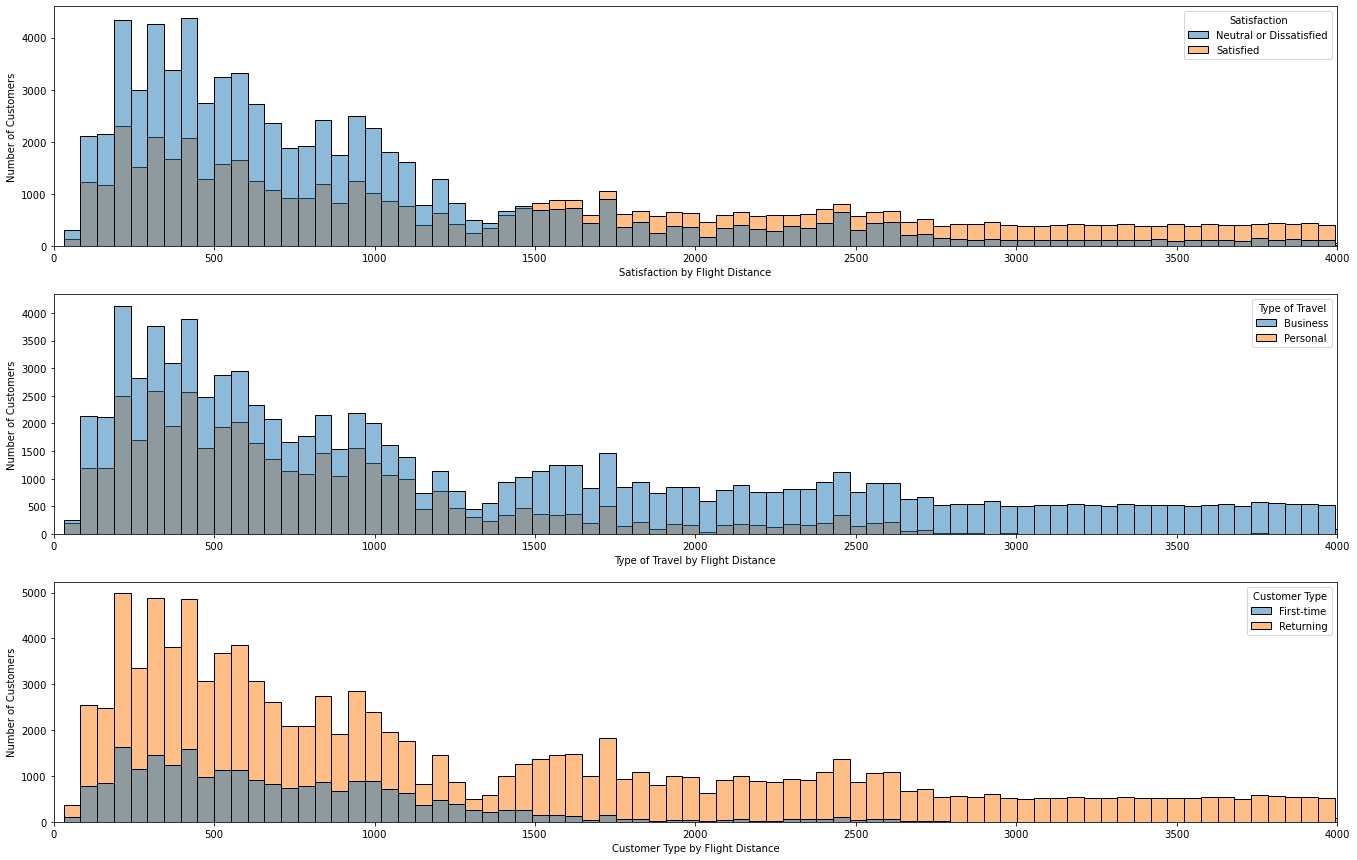

In [20]:
plt.figure(figsize = (15,15))
plt.subplot(3,1,1)
fig = plt.gcf()
fig.set_size_inches(23, 15)
plot = sns.histplot(x='Flight Distance', hue='Satisfaction', data= df,bins='auto')
plot.set(xlabel='Satisfaction by Flight Distance', ylabel = 'Number of Customers')
plt.xlim(0, 4000)
plt.subplot(3,1,2)
fig = plt.gcf()
plot = sns.histplot(x='Flight Distance', hue='Type of Travel', data= df,bins='auto')
plot.set(xlabel='Type of Travel by Flight Distance', ylabel = 'Number of Customers');
plt.xlim(0, 4000)
plt.subplot(3,1,3)
fig = plt.gcf()
plot = sns.histplot(x='Flight Distance', hue='Customer Type', data= df,bins='auto')
plot.set(xlabel='Customer Type by Flight Distance', ylabel = 'Number of Customers');
plt.xlim(0, 4000);

Does flight distance affect customer preferences or flight patterns?
The longer the flight distance was we can observe:
- After 1500 miles we can see an increase in the number of Satisfied customers to the number of neutral Dissatisfied
- After 1300 miles there is an increase in Business flights compared to the Personal 
- First-time customers focus on short and medium-distance flights.

In [21]:
# I will change Satisfaction column from categorical value to numerical one to calculate correlation between variables
df['Satisfaction'] = df['Satisfaction'].map({'Satisfied': 1, 'Neutral or Dissatisfied': 0}).astype(int)

<AxesSubplot:>

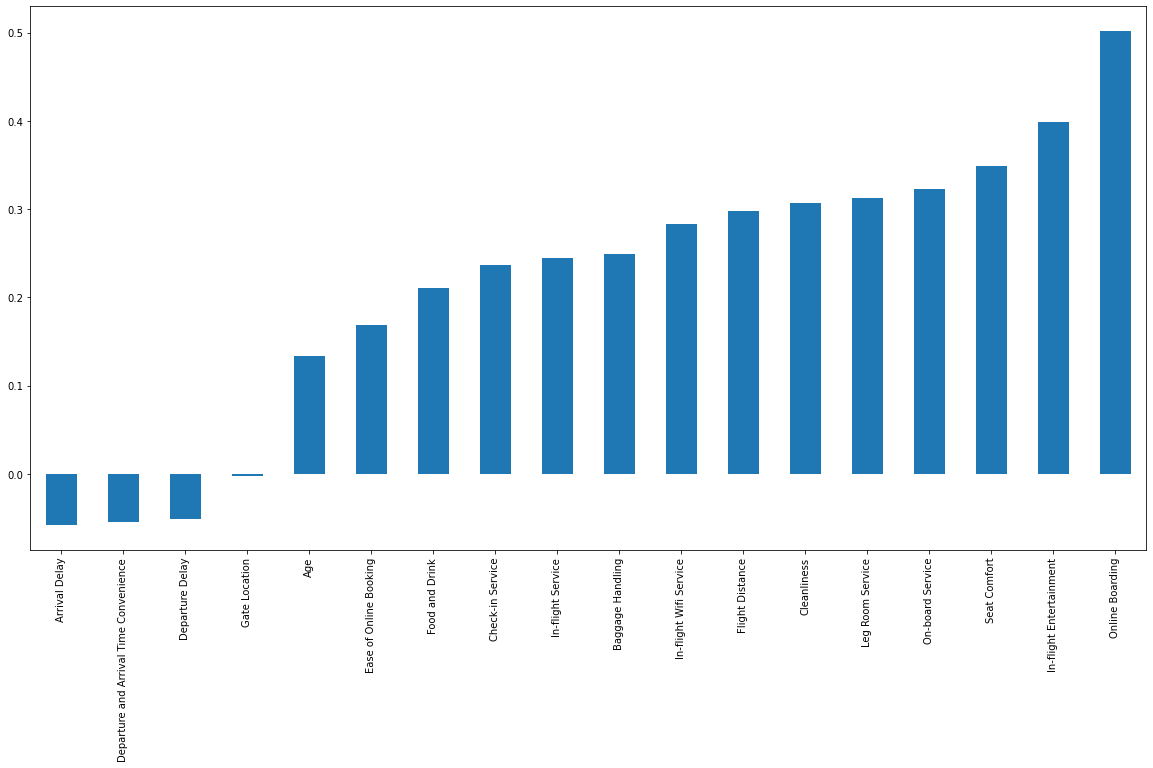

In [22]:
plt.figure(figsize=(20,10))
df.corr()['Satisfaction'].sort_values().drop('Satisfaction').plot(kind='bar')

In [23]:
X = df.iloc[:,:-1]
y= df.iloc[:,-1]

In [24]:
from sklearn.feature_selection import SelectKBest,chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
X = pd.get_dummies(X)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))  

                      Specs         Score
1           Flight Distance  9.627413e+06
3             Arrival Delay  4.311349e+04
2           Departure Delay  3.313522e+04
7           Online Boarding  1.827312e+04
23  Type of Travel_Personal  1.809602e+04
24           Class_Business  1.705053e+04
25            Class_Economy  1.442002e+04
0                       Age  1.347698e+04
16  In-flight Entertainment  1.089023e+04
22  Type of Travel_Business  8.101079e+03


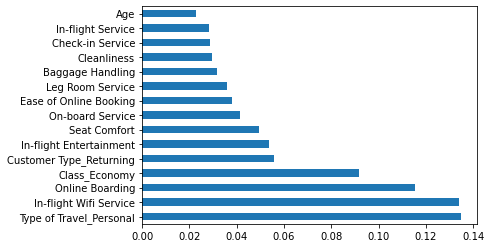

In [25]:
X = df.iloc[:,:-1]
y= df.iloc[:,-1]
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
X = pd.get_dummies(X,drop_first=True)
model.fit(X,y)
#print(model.feature_importances_) #use in built class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

Which factors contribute to customer satisfaction the most? What about dissatisfaction?
From numerical columns, we see that answers provided in a survey by customers have a big correlation with Satisfaction level. The biggest correlation has
created an Average score of those answers but Online Booking is the most correlated original one.


- Average Score             -                0.52
- Online Boarding           -                0.50
- In-flight Entertainment   -                0.39
- Seat Comfort              -                0.34
- On-board Service          -                0.32
- Leg Room Service          -                0.31
- Cleanliness               -                0.30
- Flight Distance           -                0.29
- In-flight Wifi Service    -                0.28
- Baggage Handling          -                0.24
- In-flight Service         -                0.24
- Check-in Service          -                0.23
- Food and Drink            -                0.21
- Ease of Online Booking    -                0.16
- Age                       -                0.13
- ID                        -               0.01
- Gate Location             -               -0.00
- Departure Delay                          -0.05
- Departure and Arrival Time Convenience -  -0.05
- Arrival Delay             -               -0.05

Select KBest method showed that below features will be most relevant for models:
- Flight Distance
- Arrival Delay
- Online Boarding
- Type of Travel_Personal
- Class_Business
- Class_Economy
- In-flight Entertainment
- Age
- Type of Travel_Business

I have also run ExtraTreeClassifier to see feature_importances for tree models because most of the models will come from ensemble category:
- Type of Travel_personal
- In-flight Wifi Service
- Online Boarding 
- Class_Economy
- Customer_Type Returning
- In-flight Entertainment


In [26]:
print(df['Departure Delay'].corr(df['Arrival Delay']))

0.9652911835463212


Due to the large correlation between Departure Delay and Arrival Delay I have decided to drop the Departure delay column. Arrival time 
may have a better explanation than Departure delay because it is the final feature showing DELAY.

In [27]:
df = df.drop(['Departure Delay'], axis=1)

In [28]:
X = df.iloc[:,:-1]
X = pd.get_dummies(X,drop_first=True)
y= df.iloc[:,-1]

# Creating Classifiers with all features

In [29]:
# Importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn import model_selection

X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.30, random_state=42)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

LGR = LogisticRegressionCV()
KNN = KNeighborsClassifier()
SVC = LinearSVC()
DT=DecisionTreeClassifier()
RF=RandomForestClassifier()
Bagged=BaggingClassifier()
AdaBoost=AdaBoostClassifier()
GBoost=GradientBoostingClassifier()
models = []

models.append(('LGR',LGR))
models.append(('KNN',KNN))
models.append(('SVC',SVC))
models.append(('DT',DT))
models.append(('RandomForest',RF))
models.append(('Bagged',Bagged))
models.append(('AdaBoost',AdaBoost))
models.append(('GradientBoost',GBoost))

# evaluating each model 
Final_results = pd.DataFrame(columns=['Model','F1 Score'])
names = []
for name, model in models:
    
    model_train = model.fit(X_train,y_train)
    predictions = model_train.predict(X_test)
    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    Final_results = Final_results.append({'Model':name,'Accuracy':accuracy,'Precision':precision,'recal':recall,'F1 Score':f1},ignore_index=True)

In [30]:
Final_results

,Model,F1 Score,Accuracy,Precision,recal
0,LGR,0.850289,0.871805,0.864003,0.837003
1,KNN,0.722852,0.767884,0.751902,0.695964
2,SVC,0.264862,0.625325,0.903204,0.155185
3,DT,0.936728,0.944861,0.935016,0.938447
4,RandomForest,0.956422,0.962674,0.971547,0.941761
5,Bagged,0.951107,0.958221,0.968526,0.934304
6,AdaBoost,0.916356,0.927742,0.922763,0.910038
7,GradientBoost,0.930707,0.940510,0.943178,0.918561


# Grid Search section

In Below Section I run GridSearch function so see if there is chance for improvement in models performence by selecting
different model parameters.
I have comment lines responsible for grid search fit due to long compiling time and added lines with grid search best parameters combinations inside each of model.

In [31]:
#k-nearest neighbors algorithm
param_grid_KNC = {
    'n_neighbors':[2, 3, 4,5,8,10,15],
    'weights':["uniform","distance"],
    'p':[1,2]
}
gsKNC = GridSearchCV(estimator=KNeighborsClassifier(),
                     param_grid = param_grid_KNC,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

#gsKNC = gsKNC.fit(X_train, y_train)
#KNC = KNeighborsClassifier(**gsKNC.best_params_).fit(X_train, y_train)
KNC = KNeighborsClassifier(n_neighbors=8,p=1,weights='distance').fit(X_train, y_train)

predictions_KNC = KNC.predict(X_test)
ac_KNC = accuracy_score(y_test, predictions_KNC)
cm_KNC = confusion_matrix(y_test, predictions_KNC)

#calculating precision and reall
precision_KNC = precision_score(y_test, predictions_KNC)
recall_KNC = recall_score(y_test, predictions_KNC)

f1_KNC = f1_score(y_test, predictions_KNC)

In [32]:
# Decission Tree Classifier

param_grid = { 
    'criterion' :['gini', 'entropy','log_loss'],
    'splitter':['best', 'random'],
    'max_features':['auto', 'sqrt','log2'],
    'max_depth':[5,10,15,20,30,50,70],
    
}
gstreeC = GridSearchCV(estimator=DecisionTreeClassifier(criterion='gini', random_state=1), param_grid=param_grid, cv= 5)
#gstreeC.fit(X_train,y_train)
#treeC = DecisionTreeClassifier(**gstreeC.best_params_).fit(X_train, y_train)
treeC = DecisionTreeClassifier(criterion='entropy',max_depth=15,max_features='auto',splitter='best').fit(X_train, y_train)

predictions_treeC = treeC.predict(X_test)
ac_treeC = accuracy_score(y_test, predictions_treeC)
cm_treeC = confusion_matrix(y_test, predictions_treeC)

#calculating precision and reall
precision_treeC = precision_score(y_test, predictions_treeC)
recall_treeC = recall_score(y_test, predictions_treeC)

f1_treeC = f1_score(y_test, predictions_treeC)

In [33]:
# Random Forest Classifier
param_grid = { 
    'n_estimators': [100,150,200, 500,1000,2000],
    'max_depth' : [5,10,15,70,]
}
gsRFC = GridSearchCV(estimator=RandomForestClassifier(criterion='gini', random_state=1), param_grid=param_grid, cv= 5)

#gsRFC = gsRFC.fit(X_train, y_train)
#rf = RandomForestClassifier(**gsRFC.best_params_).fit(X_train, y_train)
rf = RandomForestClassifier(max_depth=70,n_estimators=2000).fit(X_train, y_train)
predictions_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test, predictions_rf)
cm_rf = confusion_matrix(y_test, predictions_rf)

#calculating precision and reall
precision_rf = precision_score(y_test, predictions_rf)
recall_rf = recall_score(y_test, predictions_rf)

f1_rf = f1_score(y_test, predictions_rf)

In [34]:
#Gradient Boosting Classifier
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 2),
    "min_samples_leaf": np.linspace(0.1, 0.5, 2),
    "max_depth":[3,5,8],
    }

gsXG = GridSearchCV(GradientBoostingClassifier(),param_grid=param_grid, cv= 5)
#gsXG = gsXG.fit(X_train, y_train)
#XG = GradientBoostingClassifier(**gsXG.best_params_).fit(X_train, y_train)
XG = GradientBoostingClassifier(learning_rate=0.2,loss='deviance',max_depth=8,min_samples_leaf=0.1,min_samples_split=0.1).fit(X_train, y_train)

predictions_XG = XG.predict(X_test)
ac_XG = accuracy_score(y_test, predictions_XG)
cm_XG = confusion_matrix(y_test, predictions_XG)

#calculating precision and reall
precision_XG = precision_score(y_test, predictions_XG)
recall_XG = recall_score(y_test, predictions_XG)

f1_XG = f1_score(y_test, predictions_XG)

In [35]:
#AdaBoost Classifier
param_gridA = { 
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'n_estimators': [100,150,200, 500,1000,2000]
}

gsADB = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_gridA, cv= 5)
#gsADB = gsADB.fit(X_train, y_train)
#ABoost = AdaBoostClassifier(**gsADB.best_params_).fit(X_train, y_train)
ABoost = AdaBoostClassifier(learning_rate=0.15,n_estimators=2000).fit(X_train, y_train)

predictions_ABoost = ABoost.predict(X_test)
ac_ABoost = accuracy_score(y_test, predictions_ABoost)
cm_ABoost = confusion_matrix(y_test, predictions_ABoost)

#calculating precision and reall
precision_ABoost = precision_score(y_test, predictions_ABoost)
recall_ABoost= recall_score(y_test, predictions_ABoost)

f1_ABoost = f1_score(y_test, predictions_ABoost)

In [36]:
#Bagging Classifier
param_gridA = { 
    "n_estimators": [10,20,50,100,200],
    'bootstrap':[True,False],
    'bootstrap_features':[True,False],
}

gsBagg = GridSearchCV(estimator=BaggingClassifier(), param_grid=param_gridA, cv= 5)
#gsBagg = gsBagg.fit(X_train, y_train)
#Bagg = BaggingClassifier(**gsBagg.best_params_).fit(X_train, y_train)
Bagg = BaggingClassifier(bootstrap=False,bootstrap_features=True,n_estimators=200).fit(X_train, y_train)

predictions_Bagg = Bagg.predict(X_test)
ac_Bagg = accuracy_score(y_test, predictions_Bagg)
cm_Bagg = confusion_matrix(y_test, predictions_Bagg)

#calculating precision and reall
precision_Bagg = precision_score(y_test, predictions_Bagg)
recall_Bagg= recall_score(y_test, predictions_Bagg)

f1_Bagg = f1_score(y_test, predictions_Bagg)

In [37]:
KNN_list = ["KNN Classifier", ac_KNC, precision_KNC, recall_KNC, f1_KNC]
DCC_list = ['Decission Tree Classifier', ac_treeC, precision_treeC, recall_treeC, f1_treeC]
RF_list = ['Random Forest Classifier', ac_rf, precision_rf, recall_rf, f1_rf]
XGB_list = ['Gradient Boosting Classifier', ac_XG, precision_XG, recall_XG, f1_XG]
ABoost_list = ['AdaBoost Classifier', ac_ABoost, precision_ABoost, recall_ABoost, f1_ABoost]
BG_list = ['Bagging Classifier', ac_Bagg, precision_Bagg, recall_Bagg, f1_Bagg]

data_grid = [KNN_list,DCC_list,RF_list,XGB_list,ABoost_list,BG_list]
Final_results_grid = pd.DataFrame(data_grid,columns=['Model', 'Accuracy', 'Precision','Recall','F1 Score'])

In [38]:
Final_results_grid

,Model,Accuracy,Precision,Recall,F1 Score
0,KNN Classifier,0.838649,0.824698,0.798828,0.811557
1,Decission Tree Classifier,0.945556,0.946421,0.927320,0.936773
2,Random Forest Classifier,0.963472,0.972465,0.942708,0.957355
3,Gradient Boosting Classifier,0.934667,0.951112,0.895833,0.922646
4,AdaBoost Classifier,0.930522,0.925340,0.914003,0.919637
5,Bagging Classifier,0.962468,0.971591,0.941229,0.956169


The GridSearch showed small improvements for the Decission Tree, Random Forest and Enseble classifiers. For KNN Classifier we can observe significant improvement. It may be casued due to already high F1 scores or 
wrongly selected combination of models parameters. Due to low computing power I had to limit potential number of iterations which could cause not finding best combination/

# Creation of Classifier's for dataset with Average Score column

In [39]:
df_average_score = df_average_score[['Average Score','Gender', 'Age', 'Customer Type', 'Type of Travel', 'Class',
       'Flight Distance','Arrival Delay','Satisfaction']]

In [40]:
df_average_score = df_average_score.dropna()
df_average_score['Satisfaction'] = df_average_score['Satisfaction'].map({'Satisfied': 1, 'Neutral or Dissatisfied': 0}).astype(int)

In [41]:
X = df_average_score.iloc[:,:-1]
X = pd.get_dummies(X,drop_first=True)
y= df_average_score.iloc[:,-1]

In [42]:
# Importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn import model_selection

X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.30, random_state=42)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

LGR = LogisticRegressionCV()
KNN = KNeighborsClassifier()
SVC = LinearSVC()
DT=DecisionTreeClassifier()
RF=RandomForestClassifier()
Bagged=BaggingClassifier()
AdaBoost=AdaBoostClassifier()
GBoost=GradientBoostingClassifier()
models = []

models.append(('LGR',LGR))
models.append(('KNN',KNN))
models.append(('SVC',SVC))
models.append(('DT',DT))
models.append(('RandomForest',RF))
models.append(('Bagged',Bagged))
models.append(('AdaBoost',AdaBoost))
models.append(('GradientBoost',GBoost))

# evaluating each model 
Final_results_AVS = pd.DataFrame(columns=['Model','F1 Score'])
names = []
for name, model in models:
    
    model_train = model.fit(X_train,y_train)
    predictions = model_train.predict(X_test)
    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    Final_results_AVS = Final_results_AVS.append({'Model':name,'Accuracy':accuracy,'Precision':precision,'recal':recall,'F1 Score':f1},ignore_index=True)

In [43]:
Final_results_AVS

,Model,F1 Score,Accuracy,Precision,recal
0,LGR,0.828354,0.852395,0.838038,0.818892
1,KNN,0.628399,0.683039,0.641111,0.616181
2,SVC,0.147221,0.596803,0.919103,0.080019
3,DT,0.771300,0.800371,0.768648,0.773970
4,RandomForest,0.823741,0.851469,0.851199,0.798000
5,Bagged,0.808811,0.840914,0.847291,0.773674
6,AdaBoost,0.831449,0.852653,0.827356,0.835582
7,GradientBoost,0.838880,0.864906,0.871523,0.808594


Using one column as a replacement for columns coming from customer surveys is giving worse results.It reduces the time of compiling but
it affects the model's performance so my recommendation is not to use this approach. 

# Creation of Classifier's for dataset with data which is available to the company immedietly (no survey)

In [44]:
df_fast_model = df_fast_model[['Gender', 'Age', 'Customer Type', 'Type of Travel', 'Class',
       'Flight Distance','Arrival Delay','Satisfaction']]

In [45]:
df_fast_model = df_fast_model.dropna()
df_fast_model['Satisfaction'] = df_fast_model['Satisfaction'].map({'Satisfied': 1, 'Neutral or Dissatisfied': 0}).astype(int)

In [46]:
X = df_fast_model.iloc[:,:-1]
X = pd.get_dummies(X,drop_first=True)
y= df_fast_model.iloc[:,-1]

In [47]:
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.30, random_state=42)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

LGR = LogisticRegressionCV()
KNN = KNeighborsClassifier()
SVC = LinearSVC()
DT=DecisionTreeClassifier()
RF=RandomForestClassifier()
Bagged=BaggingClassifier()
AdaBoost=AdaBoostClassifier()
GBoost=GradientBoostingClassifier()
models = []

models.append(('LGR',LGR))
models.append(('KNN',KNN))
models.append(('SVC',SVC))
models.append(('DT',DT))
models.append(('RandomForest',RF))
models.append(('Bagged',Bagged))
models.append(('AdaBoost',AdaBoost))
models.append(('GradientBoost',GBoost))

# evaluating each model 
Final_results_fast = pd.DataFrame(columns=['Model','F1 Score'])
names = []
for name, model in models:
    
    model_train = model.fit(X_train,y_train)
    predictions = model_train.predict(X_test)
    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    Final_results_fast = Final_results_fast.append({'Model':name,'Accuracy':accuracy,'Precision':precision,'recal':recall,'F1 Score':f1},ignore_index=True)

In [48]:
Final_results_fast

,Model,F1 Score,Accuracy,Precision,recal
0,LGR,0.749693,0.779700,0.741066,0.758523
1,KNN,0.607687,0.664736,0.618758,0.597005
2,SVC,0.357792,0.621489,0.682667,0.242424
3,DT,0.670272,0.714341,0.673012,0.667554
4,RandomForest,0.721732,0.759518,0.726493,0.717034
5,Bagged,0.712193,0.757201,0.735072,0.690696
6,AdaBoost,0.769089,0.794090,0.750690,0.788411
7,GradientBoost,0.780102,0.803254,0.759028,0.802379


In [49]:
cm = confusion_matrix(y_test, predictions)
cm

array([[17647,  4304],
       [ 3339, 13557]], dtype=int64)

Even the model with limited number of features which will be available instantly for airlines company is giving us
good results with F1 score 0,78 and Confussion Matrix shows that company would be able to diagnose Dissatisfied customers before and try to reach them and make them use airlines again

# SUMMARY

In the notebook we have checked 3 approaches:
- We have created classification models using most of the given features coming from the airline's dataset. In this approach, I checked if limiting the number of features to 10 using SelectKbest and feat_importances from ExtraTreesClassifier would improve model performance but it did not.
- The approach with replacing survey columns with Average Score column resulted in a significant reduction in model performance comparing to first approach
- "Fast Response approach" which works only on columns available to the airline company (without survey columns) shows potential and allows the company to reach disappointed customers immediately after the landing. If the dataset would be changed and we would add columns that can give us more hard data instead of customer feelings there is potential to improve the models performence.